In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np 
!pip install mitdeeplearning
import mitdeeplearning as mdl 
!apt-get install abcmidi timidity > /dev/null 2>&1

assert len(tf.config.list_physical_devices("GPU")) > 0

In [0]:
songs = mdl.lab1.load_training_data()

In [0]:
text = "\n\n".join(songs)
print(text[:100])

X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB 


In [0]:
# Create vocabulary and two dictionaries 
vocab = list(set(text))
char2idx = {ch:i for i,ch in enumerate(vocab)}
idx2char = {i:ch for i,ch in enumerate(vocab)}
int_text = [char2idx[ch] for ch in text]
print("Has %d characters in vocabulary." %len(vocab))
print(int_text[:30])

Has 83 characters in vocabulary.
[43, 56, 37, 57, 44, 56, 46, 40, 81, 74, 36, 2, 34, 64, 2, 31, 80, 80, 81, 55, 38, 32, 1, 31, 17, 32, 57, 24, 56, 81]


In [0]:
def get_batch(arr, batch_size, seq_length):
  n = len(arr) - seq_length - 1 
  idx = np.random.choice(n, batch_size)
  x_batch = [arr[i:i+seq_length] for i in idx]
  y_batch = [arr[i+1:i+seq_length+1] for i in idx]

  x_batch = np.reshape(x_batch, [batch_size, seq_length])
  y_batch = np.reshape(y_batch, [batch_size, seq_length])

  return x_batch, y_batch 

In [0]:
# Define model 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = Sequential([
                    Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                    LSTM(rnn_units, return_sequences=True, 
                         recurrent_initializer='glorot_uniform',
                         recurrent_activation='sigmoid', stateful=True),
                    Dense(vocab_size)
  ])
  return model 

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
batch_size = 32 

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (32, None, 256)           21248     
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Define loss function 
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss 

In [0]:
@tf.function
def train_step(x, y):
  with tf.GradientTape() as g:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)
  grads = g.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss 

In [0]:
from tqdm import tqdm
# Train model 
training_iterations = 2000
learning_rate = 5e-3
seq_length = 100
optimizer = tf.keras.optimizers.Adam(learning_rate)
checkpoint = 'train_model'
losses = []

for i in tqdm(range(training_iterations)):
  x_batch, y_batch = get_batch(int_text, batch_size, seq_length)
  loss = train_step(x_batch,y_batch)
  losses.append(loss.numpy().mean())

model.save_weights(checkpoint)

100%|██████████| 2000/2000 [01:23<00:00, 24.77it/s]


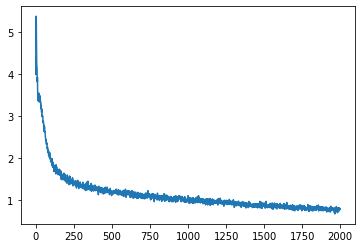

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(losses)

In [0]:
def generate_text(start_string, length_str):
  inp_val = [char2idx[s] for s in start_string]
  inp_val = np.expand_dims(inp_val, 0)
  print(inp_val)
  string = []

  for i in range(length_str):
    out = model(inp_val)
    out = tf.squeeze(out, 0)
    predicted = tf.random.categorical(out, num_samples=1)[-1, 0].numpy()
    inp_val = np.expand_dims([predicted], 0)
    string.append(idx2char[predicted])
  
  return start_string + ''.join(string)

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(checkpoint)
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_3 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [0]:
generated_text = generate_text(start_string='E', length_str=1000)

[[53]]


In [0]:
print(generated_text)

Eaf gfed|BdAc BAGB:|!
A2eA fAeA|EBBA Bcde|f2ed Bdef|gedc BGGB|cAFG AGGA|BGGd BGGB|AcBA GEE:|!
g|eaa2 edBd|eaaf gedB|DEGA BAGF|ABcA d2:|!

X:93
T:Fanny Powe
Z: id:dc-polka-8
M:2/4
L:1/8
K:A Dorian
B,|E3 BEE|F3 EDE|BAA A:|!

X:34
T:Dalaigh's
Z: id:dc-reel-362
M:C
L:1/8
K:A Dorian
C|A,A,2 CD|GFG AcB|c2A d2d|!
e2a a2f g2d|efe edB|GBd gba|gfg e2f gec|BAG A:|!

X:10
T:Kiss the Mig White
Z: id:dc-ocarolan-8
M:C
L:1/8
K:G Major
Bc|d2f2 d2ef|dcBc dedB|A2AB A2FA|Bdef edBA|Beed e2:|!
GB|AddB DAFA|DBBA BdAF|EDFD BDAD|GFEC B,EE2:|!

X:309
T:Roving Barley
Z: id:dc-slide-39
M:6/8
L:1/8
K:G Major
D2|Gg g2 f2|e2 f2 g2|dedc BGBc|dggf g2fe|!
d2cB gecA|defg a2^ga|A=BcA ed=cA|GEcE dEcGE DEGA|BAGB ADFA|!
d2|d4 e2|B4 AG|E4 FD2:|!
A|d2e f2a a2f e2d|BA Bcde|fedB cAFA|]!

X:321
T:Silver Lasses
Z: id:dc-reel-217
M:C
L:1/8
K:D Minor
C|A,DFA D2Bc|!
dAaA gAfA|eee2 Bee2|dfaf gfe^c|dc-97
M:2/4
L:1/8
K:E Dorian
E>F GA|Be B2|fe dc/B/|cA G:|!
K:A Dorian
A|d2 Bc de|dc Bc|EB,A, DB,G,|A,B,D FBdB|AFEG FDDF:|[2 GABc d2cA|!
B

In [0]:
from IPython import display as ipythondisplay

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  waveform = mdl.lab1.play_song(song)
  if waveform:
    print("Generating song ", i)
    ipythondisplay.display(waveform)